# Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
from collections import Counter
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
import torch
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install gdown

In [3]:
# import gdown 

# # The shareable link from Google Drive
# file_id = '1Kc7LSMMy72PgKVbsXAPPopQIDpUIZ7l5'
# download_url = f'https://drive.google.com/uc?id={file_id}'

# # Download the file using gdown
# output = 'Conversation_Dataset.csv'
# gdown.download(download_url, output, quiet=False)

# Now load the CSV into a pandas DataFrame
df = pd.read_csv("/kaggle/input/banking-conversation/Conversation_Dataset.csv")

# Display the first few rows
df.head()

,conversation_id,speaker,date_time,text
0,2b6544c382e6423b96785c1a135d8e95,agent,2023-09-06T14:33:33+00:00,"Good morning, thank you for calling Union Fina..."
1,2b6544c382e6423b96785c1a135d8e95,Customer,2023-09-06T14:33:41.307692+00:00,"Hi Monroe, my name is Della. I need help manag..."
2,2b6544c382e6423b96785c1a135d8e95,agent,2023-09-06T14:33:50.538461+00:00,"Of course, Della. I'd be happy to help you wit..."
3,2b6544c382e6423b96785c1a135d8e95,Customer,2023-09-06T14:34:01.153846+00:00,Sure thing. My account number is 1234567890.
4,2b6544c382e6423b96785c1a135d8e95,agent,2023-09-06T14:34:04.384615+00:00,"Thank, thank you for providing that informatio..."


In [4]:
df['date_time'] = pd.to_datetime(df['date_time'], format='ISO8601', errors='coerce')

In [5]:
def preprocess_data(df):
    """Preprocess dataset by handling missing values and formatting columns"""
    df.dropna(subset=['text'], inplace=True)
    return df

df = preprocess_data(df)

# 1. Exploratory Data Analysis (EDA)

In [6]:
print("Basic Info:")
print(df.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5531482 entries, 0 to 5532111
Data columns (total 4 columns):
 #   Column           Dtype              
---  ------           -----              
 0   conversation_id  object             
 1   speaker          object             
 2   date_time        datetime64[ns, UTC]
 3   text             object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 211.0+ MB
None


### Summary Statistics

In [7]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
                         conversation_id  speaker  \
count                            5531482  5531482   
unique                            301821        2   
top     5b0d1a6de9bd4d96ac3045b9a8f3b9ab    agent   
freq                                 486  2879903   
mean                                 NaN      NaN   
min                                  NaN      NaN   
25%                                  NaN      NaN   
50%                                  NaN      NaN   
75%                                  NaN      NaN   
max                                  NaN      NaN   

                                  date_time     text  
count                               5531482  5531482  
unique                                  NaN  4144680  
top                                     NaN     Bye.  
freq                                    NaN    37611  
mean    2023-09-15 13:33:32.571015168+00:00      NaN  
min               2023-09-01 08:00:03+00:00      NaN  
25%     202

### Missing Values Analysis

In [8]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
conversation_id    0
speaker            0
date_time          0
text               0
dtype: int64


## Conversation Length

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


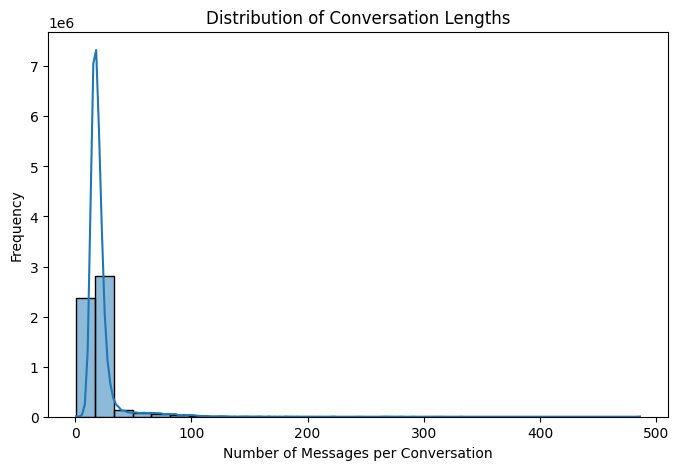

In [9]:
df['conversation_length'] = df.groupby('conversation_id')['text'].transform('count')
plt.figure(figsize=(8,5))
sns.histplot(df['conversation_length'], bins=30, kde=True)
plt.title("Distribution of Conversation Lengths")
plt.xlabel("Number of Messages per Conversation")
plt.ylabel("Frequency")
plt.show()

**1. Highly Skewed Distribution**:
- The majority of conversations have a small number of messages.
- A few conversations have a significantly higher number of messages, creating a long tail in the distribution.
  
**2. Most Conversations Are Short**:
- The highest frequency is concentrated at low message counts (likely between **5 to 20 messages**).
- This suggests that most customer interactions are **brief and to the point**.
  
**3. Few Lengthy Conversations**:
- There are some conversations with **very high message counts (100+ messages)**, but they are rare.
- These may represent **complex customer issues** requiring extensive discussions with support agents.
  
**4. Potential Implications**:
- The chatbot should be optimized for **handling short interactions efficiently** since most customer queries seem to get resolved in a few exchanges.
- The **longer conversations could indicate difficult cases**, requiring human intervention or better chatbot decision-making capabilities.

### Analyzing Long Conversations (e.g., top 5% longest conversations)

In [10]:
threshold = np.percentile(df['conversation_length'], 95)
long_conversations = df[df['conversation_length'] >= threshold]

print(f"Threshold for long conversations: {threshold} messages")
print("Sample long conversations:")
print(long_conversations.head(10))

Threshold for long conversations: 41.0 messages
Sample long conversations:
                     conversation_id   speaker  \
55  a9a661f0f4ff482f9a699d0c976ce705     agent   
56  a9a661f0f4ff482f9a699d0c976ce705     agent   
57  a9a661f0f4ff482f9a699d0c976ce705  Customer   
58  a9a661f0f4ff482f9a699d0c976ce705     agent   
59  a9a661f0f4ff482f9a699d0c976ce705  Customer   
60  a9a661f0f4ff482f9a699d0c976ce705     agent   
61  a9a661f0f4ff482f9a699d0c976ce705  Customer   
62  a9a661f0f4ff482f9a699d0c976ce705  Customer   
63  a9a661f0f4ff482f9a699d0c976ce705     agent   
64  a9a661f0f4ff482f9a699d0c976ce705     agent   

                          date_time  \
55        2023-09-21 13:12:44+00:00   
56 2023-09-21 13:12:51.384615+00:00   
57 2023-09-21 13:12:58.769230+00:00   
58 2023-09-21 13:13:01.999999+00:00   
59 2023-09-21 13:13:09.846153+00:00   
60 2023-09-21 13:13:22.307691+00:00   
61 2023-09-21 13:13:34.769229+00:00   
62 2023-09-21 13:13:43.076921+00:00   
63 2023-09-21 13:13:47.

## Sentiment Analysis

In [11]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


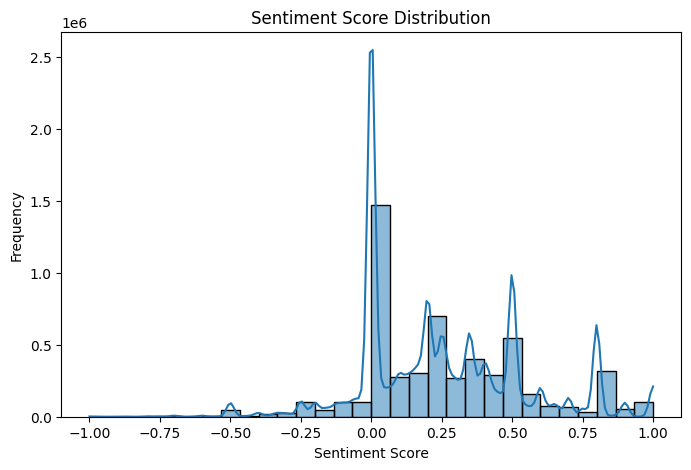

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

**1. Majority of Sentiments Are Neutral (Score Around 0.0)**
- There is a strong peak at **0.0 sentiment score**, suggesting that many conversation utterances are **neutral** in tone.
- This might indicate a high volume of factual, non-emotional exchanges (e.g., customers asking questions and agents responding with standard information).

**2. Positive Sentiments Are More Frequent Than Negative Ones**
- The distribution shows a **right-skewed tendency**, meaning that **more messages have positive sentiment scores (> 0)** than negative scores.
- Peaks at **0.25, 0.5, and 0.75** suggest that many conversations have **some degree of positivity**, which could indicate satisfactory customer service interactions.
  
**3. Few Strongly Negative Sentiments**
- The left side of the distribution (**sentiment scores < -0.3**) has relatively lower frequency.
- This suggests that there are fewer negative conversations, but they do exist, potentially indicating **dissatisfied customers** or unresolved issues.

### Sentiment Analysis for long conversations

<ipython-input-13-fcfee6d7de26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_conversations['sentiment'] = long_conversations['text'].apply(get_sentiment)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


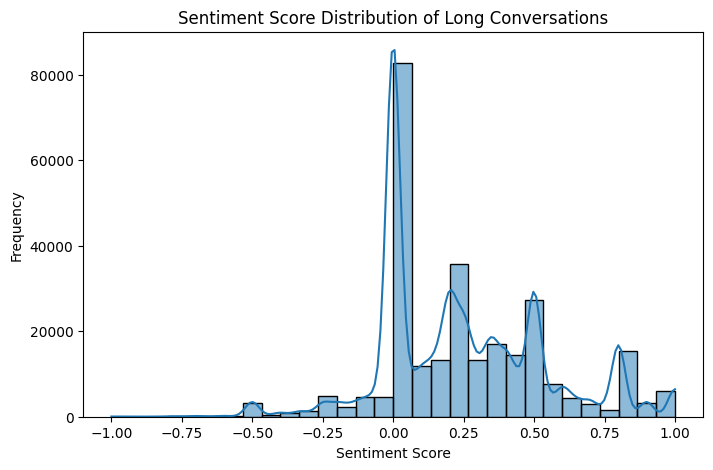

In [13]:
long_conversations['sentiment'] = long_conversations['text'].apply(get_sentiment)

plt.figure(figsize=(8,5))
sns.histplot(long_conversations['sentiment'], bins=30, kde=True)
plt.title("Sentiment Score Distribution of Long Conversations")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

**1. Neutral Sentiment Dominates**
- There is a **sharp peak at sentiment score ~0.0**, indicating that **most long conversations remain neutral**.
- This suggests that these conversations may be **factual, transactional, or unresolved discussions** rather than emotionally driven.
  
**2. Bimodal/Multimodal Sentiment Distribution**
- There are multiple smaller peaks **in the positive range (~0.25, ~0.5, ~0.75, ~1.0)** and **some in the negative range (~-0.25, ~-0.5)**.
- This suggests that while some long conversations **lead to positive resolutions**, others involve **frustration or dissatisfaction**.
  
**3. Presence of Negative Sentiment**
- The presence of **negative sentiment scores (< 0)** indicates **unhappy customers or difficult interactions**.
- These conversations could involve **complaints, disputes, or repeated follow-ups** without clear resolution.
  
**4. Long Conversations Do Not Always Mean Satisfaction**
- If long conversations had **mostly positive sentiment**, it would imply helpful and engaging discussions.
- However, the high neutral and mixed sentiment distribution suggests that **many long interactions do not lead to high satisfaction**.

### Analyzing Negative Sentiment Conversations

In [14]:
negative_sentiment_df = df[df['sentiment'] < -0.3]
print("Sample Negative Sentiment Conversations:")
print(negative_sentiment_df[['conversation_id', 'speaker', 'text', 'sentiment']].head(10))

Sample Negative Sentiment Conversations:
                      conversation_id   speaker  \
33   0b440381fd274b96af00baf8c4384310     agent   
137  7a9c3108f9064c05ab236d1264d788bd  Customer   
191  4e060b6b55ca49939bacfc1d421fb984     agent   
281  ad41cf05815f461492f4d8116a8a4556     agent   
301  cd6b591087e34f58902e13f6c15af2be  Customer   
308  cd6b591087e34f58902e13f6c15af2be  Customer   
408  8f78db8a82b4442e8b95cf39125bc25f  Customer   
420  2423483f1f9f4ac9a28212c8ecd11ba8  Customer   
466  03541de4c37f45e0855a9054cd33420a  Customer   
603  a38a597fcbfd4365b1fb3a2a3291b7cc     agent   

                                                  text  sentiment  
33   Of course, Avis. Sorry to hear that. Can you p...  -0.500000  
137  Seriously? This is ridiculous. My mother's mai...  -0.333333  
191  Sorry to hear that Ag Agnes. Can you please pr...  -0.500000  
281  Alright, sorry you please provide me with your...  -0.500000  
301  (frustrated) That's unacceptable! I've been tr...  -

### Identify resolved vs unresolved conversations

In [15]:
df['query_resolved'] = df['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))
resolved_conversations = df[df['query_resolved']]
unresolved_conversations = df[~df['query_resolved']]

### Compare sentiment trends in resolved vs unresolved conversations

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


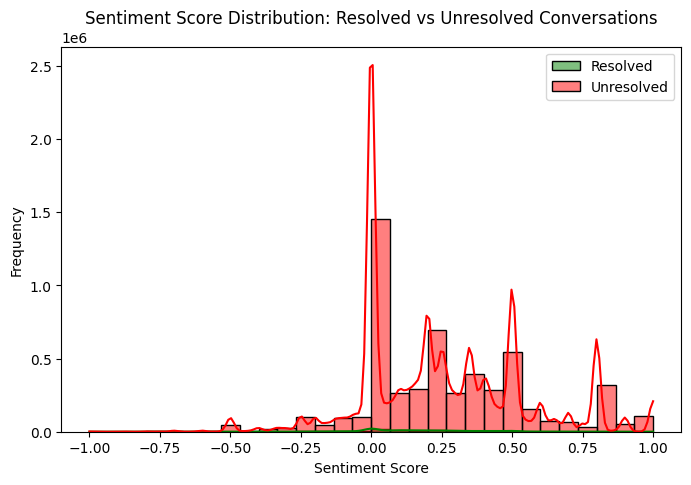

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(resolved_conversations['sentiment'], bins=30, kde=True, color='green', label='Resolved')
sns.histplot(unresolved_conversations['sentiment'], bins=30, kde=True, color='red', label='Unresolved')
plt.title("Sentiment Score Distribution: Resolved vs Unresolved Conversations")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**1. Majority of Unresolved Conversations Are Neutral**
- There is a **strong peak around 0.0 (neutral sentiment) for unresolved conversations (red)**.
- This suggests that many unresolved conversations are **informational or lack strong emotion**, possibly due to **customers dropping off before expressing frustration or satisfaction**.
- If a conversation remains neutral but unresolved, it may indicate **ineffective responses or lack of clear resolutions**.

**2. Unresolved Conversations Have a Higher Spread of Negative Sentiment**
- There is **a noticeable presence of negative sentiment (left side of the plot, < 0 sentiment score) in unresolved conversations**.
- This indicates that **many unresolved cases involve frustrated or dissatisfied customers**.
- If a conversation **remains unresolved and carries a negative sentiment, it is a major risk for customer churn or complaints**.

**3. Resolved Conversations Have a Higher Frequency in the Positive Range**
- **Resolved conversations (green) are more likely to have a positive sentiment score (> 0.3)**.
- This suggests that when an issue is successfully resolved, **customers tend to express positive sentiment**.
- However, the green curve is much smaller, indicating that **only a small fraction of conversations are actually getting resolved**.

**4. Resolved Conversations Are Rare and Less Frequent Overall**
- The **green bars (resolved cases) are significantly smaller than the red ones**, meaning **most conversations remain unresolved**.
- This confirms a **low query resolution rate**, as seen in previous metrics.

### Extract key reasons behind negative sentiment in long conversations

In [20]:
long_conversations = df[df.groupby('conversation_id')['text'].transform('count') > np.percentile(df.groupby('conversation_id')['text'].count(), 95)]
negative_long_conversations = long_conversations[long_conversations['sentiment'] < -0.3]

## Word Cloud for Agent & Customer Messages

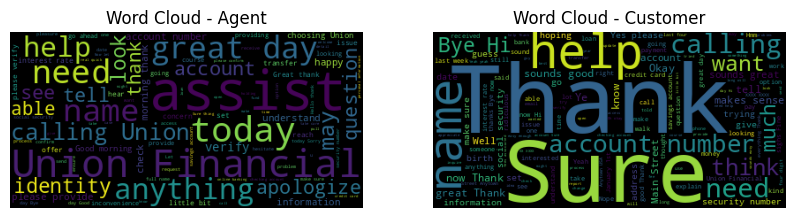

In [19]:
agent_text = ' '.join(df[df['speaker'] == 'agent']['text'])
customer_text = ' '.join(df[df['speaker'] == 'Customer']['text'])

if agent_text.strip() and customer_text.strip():
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Word Cloud - Agent")
    plt.imshow(WordCloud(width=400, height=200).generate(agent_text))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Word Cloud - Customer")
    plt.imshow(WordCloud(width=400, height=200).generate(customer_text))
    plt.axis("off")
    plt.show()
else:
    print("No sufficient text data for word cloud generation")

**Agent's Word Cloud**

Common words: "**assist**," "**help**," "**verify**," "**identity**," "**Union Financial**", "**apologize**", "**question**"
- Agents frequently use **supportive and professional language**, focusing on assistance and verification.
- Words like "**identity**" and "**verify**" suggest that many conversations involve security and authentication.
- The presence of "**apologize**" indicates that agents are handling complaints or service issues.
- "**Great day**" implies that agents often use polite and closing remarks.

**Customer's Word Cloud**

Common words: "**Thank**," "**Sure**", "**help**", "**name**", "**account**", "**number**", "**calling**", "**think**"
- Customers often express **gratitude** (e.g., "Thank," "Sure"), indicating that many interactions are **positive**.
- Words like "**account**," "**number**," "**name**" suggest that customers frequently inquire about **account-related services**.
- The presence of **"need," "help," and "calling"** suggests customers are seeking assistance or clarifications.
- "**Think**" may indicate uncertainty in some queries.

### Extracting Agent Responses Containing Apologies

In [21]:
apology_keywords = ['sorry', 'apologize', 'regret', 'inconvenience', 'unfortunately']
def contains_apology(text):
    return any(word in text.lower() for word in apology_keywords)

apology_responses = df[(df['speaker'] == 'agent') & (df['text'].apply(contains_apology))]

print("Sample Apology Responses:")
print(apology_responses[['conversation_id', 'text']].head(10))

Sample Apology Responses:
                      conversation_id  \
19   41e9647097e84e829964f2dc9f8fb27e   
21   41e9647097e84e829964f2dc9f8fb27e   
23   41e9647097e84e829964f2dc9f8fb27e   
33   0b440381fd274b96af00baf8c4384310   
41   0b440381fd274b96af00baf8c4384310   
110  a9a661f0f4ff482f9a699d0c976ce705   
130  7a9c3108f9064c05ab236d1264d788bd   
140  7a9c3108f9064c05ab236d1264d788bd   
191  4e060b6b55ca49939bacfc1d421fb984   
195  4e060b6b55ca49939bacfc1d421fb984   

                                                  text  
19   Sorry to hear that, Margery. Can you tell me m...  
21   I see. We apologize for any inconvenience this...  
23   I apologize for the confusion, Margery. It's p...  
33   Of course, Avis. Sorry to hear that. Can you p...  
41   I understand your frustration, Avis. Unfortuna...  
110  Sorry to hear that, Jewel. Can you please veri...  
130  Of course, Faye. I apologize for any inconveni...  
140  Yes, that's all I need. I apologize again for ...  
191  Sorr

## Response Time Calculation

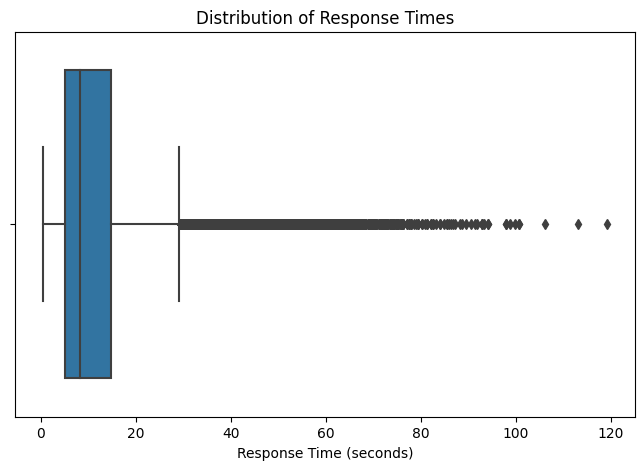

In [22]:
df['response_time'] = df.groupby('conversation_id')['date_time'].diff().dt.total_seconds()

plt.figure(figsize=(8,5))
sns.boxplot(x=df['response_time'].dropna())
plt.title("Distribution of Response Times")
plt.xlabel("Response Time (seconds)")
plt.show()

**1. Most Responses Are Quick (Below ~20 Seconds)**
- The **interquartile range (IQR)** (the box portion of the plot) is mostly **between 0 and 20 seconds**, meaning **most agent responses are given within this timeframe**.
- This suggests that **customer queries are being handled efficiently**.

**2. Presence of Outliers (Long Response Times)**
- There are **many outliers beyond 40+ seconds**, stretching up to **120 seconds**.
- These **outliers indicate cases where responses took significantly longer**, possibly due to:
  
     -> **Complex queries** requiring additional verification or lookup.
  
     -> **Agents multitasking** or handling multiple customers simultaneously.
  
     -> **System delays** in retrieving information.
  
**3. Skewed Distribution**
- The presence of **a long tail of response times** suggests that while **most responses are quick, some conversations face significant delays**.
- A further investigation into **why certain responses take longer** could help in optimizing customer support.

**4. Potential Optimizations**
- **Identify reasons behind longer response times**—whether it’s technical delays, agent availability, or complex inquiries.
- **Improve chatbot automation** for common queries to reduce agent workload.
- **Monitor peak load times** when agents might be handling multiple requests simultaneously.

### Analyzing Queries with Long Response Times

In [23]:
threshold = np.percentile(df['response_time'].dropna(), 90)  # Top 10% longest response times
longest_response_df = df[df['response_time'] >= threshold]

print(f"Threshold for long response times: {threshold} seconds")
print("Sample Queries with Long Response Times:")
print(longest_response_df[['conversation_id', 'speaker', 'text', 'response_time']].head(10))

Threshold for long response times: 21.230769 seconds
Sample Queries with Long Response Times:
                      conversation_id   speaker  \
22   41e9647097e84e829964f2dc9f8fb27e  Customer   
24   41e9647097e84e829964f2dc9f8fb27e  Customer   
26   41e9647097e84e829964f2dc9f8fb27e  Customer   
85   a9a661f0f4ff482f9a699d0c976ce705  Customer   
141  7a9c3108f9064c05ab236d1264d788bd  Customer   
154  7c9cae3732dd4696995949b0626abaf1  Customer   
163  1c82811b8ffe45c898638eea43d0e2a8  Customer   
165  1c82811b8ffe45c898638eea43d0e2a8  Customer   
167  1c82811b8ffe45c898638eea43d0e2a8  Customer   
169  1c82811b8ffe45c898638eea43d0e2a8  Customer   

                                                  text  response_time  
22   Sure, I alreadyll do that right away. But I wa...      23.538462  
24   Okay's good to know. But what can I do to prot...      25.846154  
26     That makes sense. Thanks for the advice, Mitzi.      24.461538  
85   That sounds great! I think I'd like to go with...  

## Most Common Words Analysis

In [24]:
stop_words = set(stopwords.words('english'))
def get_most_common_words(texts, n=20):
    words = nltk.word_tokenize(' '.join(texts))
    words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]
    return Counter(words).most_common(n)

most_common_words = get_most_common_words(df['text'].dropna().astype(str))
common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

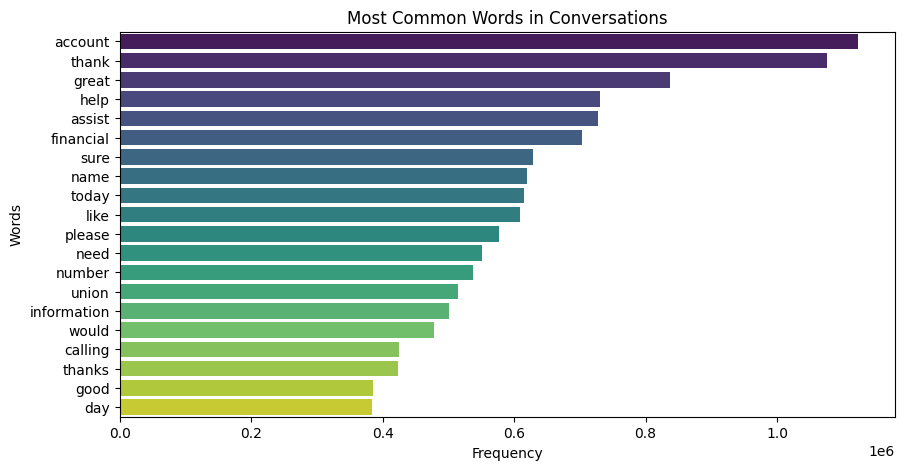

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')
plt.title("Most Common Words in Conversations")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

**1. Key Topics in Customer Conversations**
- The most frequent word is "**account**", indicating that a **large portion of conversations revolve around account-related inquiries** (e.g., account creation, access issues, transactions).
- Other high-frequency words like "**financial**," "**information**," "**number**," and "**union**" suggest common topics related to **banking services and customer verification**.

**2. Positive Interaction Indicators**
- The presence of words like **"thank," "great," "sure," "good," "day"** suggests that many conversations end positively, with customers acknowledging the support they received.
- This aligns with **high customer satisfaction for many interactions**.

**3. Common Actions and Requests**
- Words like **"help," "assist," "please," "need," and "calling"** indicate that **customers frequently seek assistance and request information**.
- This suggests that a **chatbot or support automation** can be optimized to handle these common queries.

**4. Potential Areas for Optimization**
- Since **"account" and "financial"** appear frequently, analyzing **subtopics within these conversations** can help identify **specific pain points (e.g., login issues, transaction problems)**.
- If **"please" and "need"** are frequently associated with delayed responses or unresolved queries, those areas may need **improved automation or agent training**.

### Identifying Most Common Words in Long Conversations

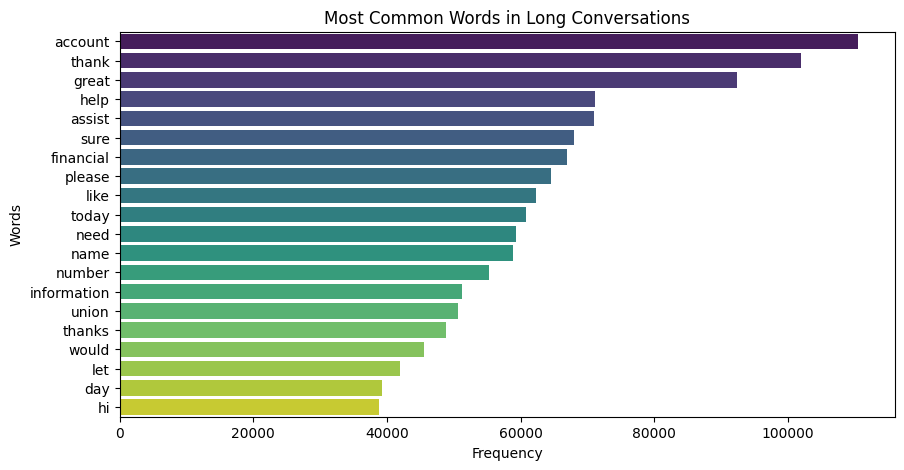

In [26]:
most_common_words_long = get_most_common_words(long_conversations['text'].dropna().astype(str))
common_words_long_df = pd.DataFrame(most_common_words_long, columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_words_long_df, palette='viridis')
plt.title("Most Common Words in Long Conversations")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

**1. Customer Service-Oriented Words Dominate**
- Words like **"thank," "great," "assist," "help," "please," and "welcome"** suggest that many long conversations involve **customer service interactions**.
- The high frequency of "assist" and "help" indicates many customers require detailed guidance.
  
**2. Frequent Account-Related Discussions**
- The prominence of **"account," "financial," "number," and "union"** suggests that **a large number of long conversations are related to account issues, financial transactions, or bank-related services**.
- This could mean customers **face difficulties with account management, verifications, or transactions** that require lengthy assistance.
  
**3. Politeness & Formality in Conversations**
- Words like **"thank," "sure," "please," and "like"** show that even long conversations remain **polite and professional**.
- This might indicate **customers and agents maintaining a professional tone even in extended discussions**.
  
**4. Potential Customer Frustration Indicators**
- The presence of **"need" and "information"** suggests that some long conversations may involve **customers repeatedly requesting clarifications**.
- This could indicate that customers **aren’t getting clear, immediate answers, leading to extended conversations**.

### Most Common Words in Negative Sentiment Conversations

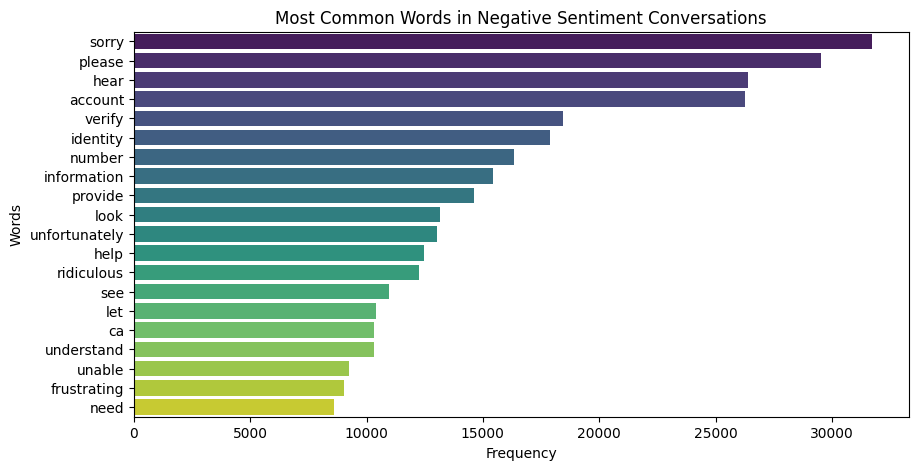

In [27]:
most_common_words_negative = get_most_common_words(negative_sentiment_df['text'].dropna().astype(str))
common_words_negative_df = pd.DataFrame(most_common_words_negative, columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_words_negative_df, palette='viridis')
plt.title("Most Common Words in Negative Sentiment Conversations")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

**1. Apologies and Frustration Indicators**
- The **most frequent word is "sorry"**, indicating that customer service agents or chatbots frequently apologize in negative sentiment conversations.
- Words like **"unfortunately" and "frustrating"** suggest that many interactions involve **bad news, unresolved issues, or delays**.
- The presence of **"ridiculous"** shows **customer frustration**, possibly due to perceived inefficiencies.
  
**2. Verification and Account Issues Are a Major Concern**
- Frequent words such as **"account," "verify," "identity," and "number"** suggest that **account access, authentication, and identity verification are major pain points**.
- Customers may be struggling with **logging in, proving their identity, or verifying transactions**, leading to **frustration**.
  
**3. Information and Assistance Requests**
- Words like **"help," "information," "provide," and "look"** indicate that **many negative sentiment conversations involve customers struggling to get the information they need**.
- This could mean:
    -> **Confusing policies** that need clearer explanations.
    -> **Ineffective chatbot responses** that do not provide satisfactory answers.
  
**4. Customers Feel Stuck or Unable to Proceed**
- Words like **"unable," "need," "understand," and "see"** suggest that customers **struggle to complete a process or do not understand the provided information**.
- This implies that some customers are **left without a clear resolution**.

### Most Common Words in Negative Long Conversations

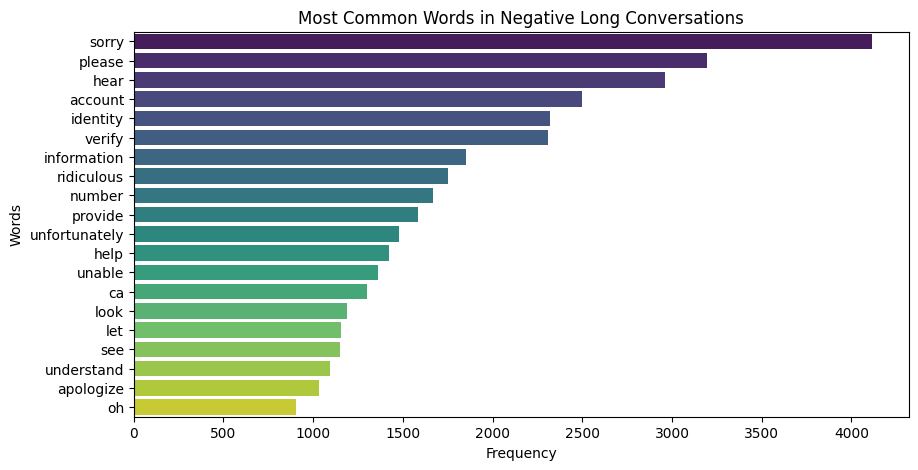

In [28]:
most_common_words_negative_long = get_most_common_words(negative_long_conversations['text'].dropna().astype(str))
common_words_negative_long_df = pd.DataFrame(most_common_words_negative_long, columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_words_negative_long_df, palette='viridis')
plt.title("Most Common Words in Negative Long Conversations")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

**1. Apologies Are Overused Without Resolution**
- The most common words are **"sorry" and "apologize"**, indicating that **many long negative conversations involve repeated apologies**.
- This suggests that instead of providing effective solutions, agents or chatbots are **offering apologies without resolving the issue**, leading to **extended and frustrating interactions**.
- The presence of **"unfortunately"** further supports this—often used when **agents fail to meet customer expectations**.
  
**2. Verification and Account Issues Are Major Pain Points**
- Words like **"account," "identity," "verify," and "number"** indicate that **many negative long conversations involve verification-related frustrations**.
- Possible reasons:
  
    -> **Customers struggling with login/access issues** and unable to proceed.
  
    -> **Repeated verification requests** causing frustration.
  
    -> **Strict security measures leading to delays** in resolution.
  
- The word **"information"** suggests that customers **seek clarity or additional details, possibly due to vague or complex verification steps**.
  
**3. Strong Customer Frustration Indicators**
- Words like **"ridiculous" and "unable"** indicate that customers are **not just dissatisfied but actively frustrated**.
- If customers **describe a situation as "ridiculous"**, it suggests that they **feel the process is unreasonable or unnecessarily difficult**.
- The presence of **"help"** implies that despite extended conversations, **customers feel they are not actually getting assistance**.
  
**4. Customers Feel Stuck or Misunderstood**
- Words like **"let", "see", "look", "understand"** indicate that customers **seek explanations or alternatives but are not receiving clear answers**.
- This suggests that many long negative conversations involve **miscommunication, unhelpful responses, or lack of proper guidance**.

### Most Common Words in Apology Responses

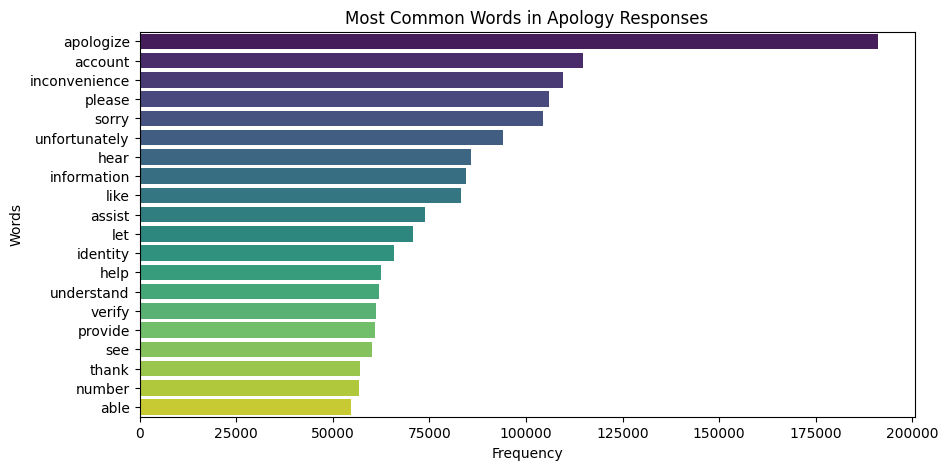

In [29]:
most_common_words_apology = get_most_common_words(apology_responses['text'].dropna().astype(str))
common_words_apology_df = pd.DataFrame(most_common_words_apology, columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_words_apology_df, palette='viridis')
plt.title("Most Common Words in Apology Responses")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

**1**. **Apologies Are Frequent**
- The most common word is "**apologize**", along with "**sorry**" and "**inconvenience**", suggesting that **many interactions involve customer frustration and service issues**.
- The presence of "**unfortunately**" indicates that many responses contain **bad news, limitations, or unresolved issues**.
  
**2**. **Common Topics in Apology Conversations**
- "**Account**," "**identity**," "**verify**," and "**number**" suggest that **many apologies are related to account verification and authentication issues**.
- "**Information**," "**assist**," "**help**," and "**understand**" indicate that customers often struggle to get the information they need, leading to frustration.
  
**3**. **Repetitive Apologies Without Clear Resolutions**
- The presence of "**please**" and "**let**" suggests that many apology responses request additional information from the customer.
- If customers are frequently being asked to **verify their identity or provide information**, it might indicate **a broken process or unnecessary friction** in customer interactions.
  
**4**. **Politeness vs. Effectiveness**
- Words like "**thank**," "**see**," and "**able**" suggest that many responses **remain polite and professional**.
- However, politeness **alone does not solve customer problems**—if apologies are common but resolution rates remain low, **customer frustration may increase**.

### Most Common Words in Long Response Queries

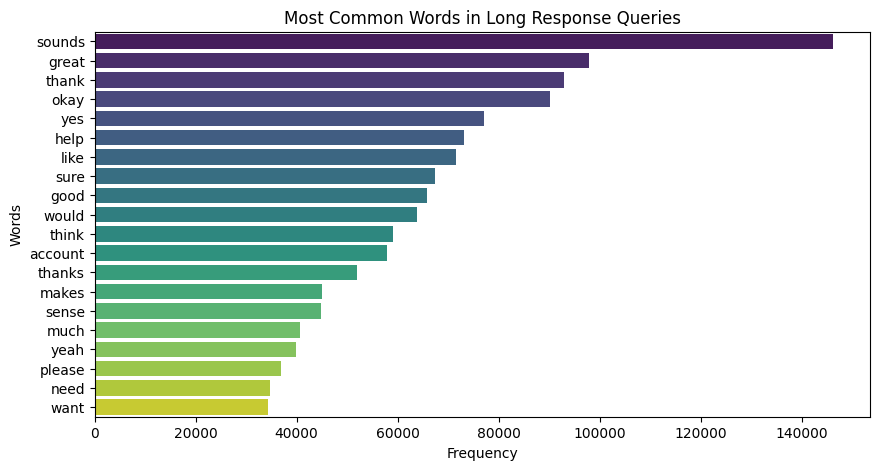

In [30]:
most_common_words_long_response = get_most_common_words(longest_response_df['text'].dropna().astype(str))
common_words_long_response_df = pd.DataFrame(most_common_words_long_response, columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_words_long_response_df, palette='viridis')
plt.title("Most Common Words in Long Response Queries")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

**1. High Frequency of Acknowledgment Words**
- Words like "**sounds**," "**great**," "**thank**," "**okay**," "**yes**," "**sure**," and "**good**" indicate that many long conversations involve **customer confirmations, acknowledgments, or back-and-forth exchanges**.
- This suggests that **some conversations might be unnecessarily prolonged** due to repeated confirmations.
  
**2. Common Assistance-Related Terms**
- The presence of "**help**" and "**please**" indicates that **many long queries involve customers actively seeking assistance**.
- This could suggest that **customers require additional clarification** or **repeat their questions** due to **unclear responses from the chatbot or agent**.
  
**3. Complexity in Decision-Making**
- Words like "**would**," "**think**," "**makes sense**", and "**much**" suggest that **some conversations involve decision-making or explanations**.
- This could mean:
  
   -> Customers are **evaluating options** before making a decision.
  
   -> Agents or chatbots are **providing detailed responses that take time to process**.
  
**4. Account-Related Issues**
- The presence of "**account**" in long queries indicates that **account-related concerns often lead to prolonged conversations**.
- This suggests that **authentication, verification, or account access issues might be complex and require multiple steps to resolve**.
  
**5. Customer Needs and Requests**
- Words like "**want**," "**need**," and "**yeah**" indicate that **many customers have specific requirements** that might not be immediately fulfilled.
- If customers repeatedly state their needs, this could mean **they are not getting direct or actionable answers**.

### Identifying Escalation Points: When Human Intervention is Needed

In [31]:
def detect_escalation(text):
    escalation_keywords = ["speak to agent", "transfer to representative", "this is frustating", "need help now", "talk to manager", "not helpful", "escalate", "not working"]
    return any(word in text.lower() for word in escalation_keywords)

df['escalation_flag'] = df['text'].apply(detect_escalation)
escalation_cases = df[df['escalation_flag']]

print("Sample Escalation Cases:")
print(escalation_cases[['conversation_id', 'text']].head(10))

Sample Escalation Cases:
                       conversation_id  \
273   47b56f4a736e489ab547ece6827d0107   
299   cd6b591087e34f58902e13f6c15af2be   
366   942ccebbad544930a3c559c11b90ab26   
379   6358fe46566c48c68e608f9d5eed8ce7   
739   72a6ad578cb246bc8779f5f2949b2d04   
887   81c5d0381b94417eb83c5fd792409122   
1186  5e02768c8f3f4fb9aa48bf1624183286   
1650  fa7b6bcb2e1f43e5a08c6000c49e469c   
1751  5db0de44d2984b51bf9e84b2f1af9148   
2830  57d9c296e53643cc8ac19d6186af39d3   

                                                   text  
273   (frighing) Yeah, like I was telling the other ...  
299   I, I was told that there were no available saf...  
366   Ireassuringly) I understand your doubions, Rah...  
379   Thank you for holding, Wade. I've reviewed you...  
739   Thank you, Ona. I'm going to check on this for...  
887   I understand your frustration, Isabella. Unfor...  
1186  Ofsolutely, Jayla. I'll make sure to escalate ...  
1650  Hi, I, I was just on the phone with someon

### Most Common Words in Escalation Cases

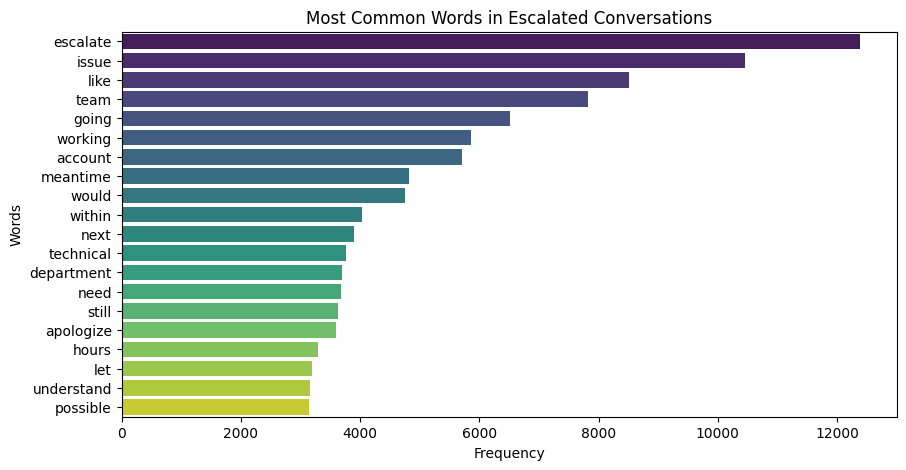

In [32]:
most_common_words_escalation = get_most_common_words(escalation_cases['text'].dropna().astype(str))
common_words_escalation_df = pd.DataFrame(most_common_words_escalation, columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_words_escalation_df, palette='viridis')
plt.title("Most Common Words in Escalated Conversations")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

**1. Escalation is a Recurring Theme**
- The most frequent word is **"escalate"**, confirming that many customers explicitly **request escalation** or agents **proactively escalate issues**.
- **"Issue"** being the second most frequent word suggests that **escalations primarily occur due to unresolved problems** rather than general inquiries.

**2. Technical and Account-Related Problems Are Major Escalation Triggers**
- Words like **"technical", "department", "working", "account"** suggest that **many escalations involve system failures, access issues, or account-related complications**.
- If customers repeatedly escalate due to **technical problems**, this might indicate **ongoing service outages, login difficulties, or platform-related issues**.

**3. Customers Seek Confirmation and Timelines**
- Words like **"team," "going," "meantime," "within," "next," "hours"** suggest that customers **frequently ask about response times or expected resolutions**.
- This implies that customers may **feel uncertain or frustrated about delays** and seek clarity on when their issue will be resolved.
- The presence of **"still"** suggests that some escalations occur because **customers feel stuck waiting for a resolution**.

**4. Apologies Are Frequently Used**
- The word **"apologize"** appears frequently, suggesting that **many escalated cases involve agents issuing apologies**.
- However, given the **low resolution rate in apology-based conversations (3.38%)**, this implies that **apologies are not effectively resolving customer concerns**.

**5. Customers Express Need for Action**
- The presence of **"need," "possible," "understand," and "let"** suggests that many escalations **happen because customers are requesting urgent action or seeking an alternative solution**.
- If customers frequently **use words like "need" and "possible"**, it means they **lack confidence in the standard process** and are pushing for a different approach.

## Query Resolution Analysis

In [33]:
# df['query_resolved'] = df['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))
resolution_rate = df.groupby('conversation_id')['query_resolved'].any().mean()
print(f"Query Resolution Rate: {resolution_rate: .2%}")

Query Resolution Rate:  19.12%


**1. Low Resolution Rate → High Drop-off or Escalations**
- A resolution rate below **20%** suggests that **most queries are either unresolved, require follow-ups, or escalate to human agents**.
- This could be due to **poor chatbot efficiency, agent delays, or complex issues that aren't being handled well**.

**2. Potential Causes for Low Query Resolution Rate**
- **Unclear or incomplete responses** from the chatbot/agents, leading to **customer frustration**.
- **Lengthy conversations without clear resolutions**, causing customers to abandon queries or switch channels (e.g., call support).
- **Technical limitations** where the bot or agent lacks access to necessary information to resolve certain requests.

**3. Impact on Customer Satisfaction**
- Since most queries remain unresolved, **customer dissatisfaction is likely high**.
- **Negative sentiment** may increase in conversations where customers don't receive clear answers.
- A high volume of unresolved queries may **increase support costs**, as customers need to **re-engage** multiple times.

**Query Resolution Analysis for Long Conversations**

In [34]:
long_conversations['query_resolved'] = long_conversations['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))
resolution_rate_long = long_conversations.groupby('conversation_id')['query_resolved'].any().mean()
print(f"Query Resolution Rate for Long Conversations: {resolution_rate_long:.2%}")

Query Resolution Rate for Long Conversations: 29.76%


<ipython-input-34-082fd28d941b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_conversations['query_resolved'] = long_conversations['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))


**1. Most Long Conversations End Without Resolution**
- **Over 70% of long conversations remain unresolved**, meaning customers **either abandon the conversation, require follow-ups, or escalate the issue**.
- This suggests that **long interactions do not necessarily lead to better outcomes**, but rather indicate **complex or difficult-to-resolve queries**.
  
**2. Causes of Low Resolution in Long Conversations**
- **Complex or multi-step processes**: Many of these conversations may involve **account verification, transaction disputes, or technical issues** that require multiple steps.
- **Unclear responses or repetitive confirmations**: Customers might be **looping through repetitive interactions** without receiving a clear solution.
- **Poor chatbot or agent efficiency**: The conversation might take long because **the bot/agent is unable to provide a direct resolution quickly**.
- **Customer frustration and drop-offs**: If customers feel like they are not making progress, they might abandon the conversation before resolution.
  
**3. Impact on Customer Experience**
- A low resolution rate for long conversations means that **customers are investing time without getting results**, leading to **frustration and dissatisfaction**.
- Customers who spend a long time in conversations **expect a resolution**, so failing to provide one may harm brand reputation and trust.
- This could **increase customer churn**, as unresolved issues push customers to seek alternatives.

**Query Resolution Analysis for Negative Sentiment Conversations**

In [35]:
negative_sentiment_df['query_resolved'] = negative_sentiment_df['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))
resolution_rate_negative = negative_sentiment_df.groupby('conversation_id')['query_resolved'].any().mean()
print(f"Query Resolution Rate for Negative Sentiment Conversations: {resolution_rate_negative:.2%}")

Query Resolution Rate for Negative Sentiment Conversations: 2.22%


<ipython-input-35-0c6d4f854f74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_sentiment_df['query_resolved'] = negative_sentiment_df['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))


**1. Extremely Low Resolution for Unhappy Customers**
- **Only ~2 out of 100 negative sentiment conversations are resolved**, which suggests that **most complaints, frustrations, and dissatisfaction remain unaddressed**.
- This implies that **customers who are already frustrated are not getting the resolution they need**, leading to **worsening customer experience**.
  
**2. Possible Causes of Low Resolution Rate**
- **Agents or chatbots failing to provide effective solutions**: Customers with complaints might **not receive actionable responses**.
- **Customers abandoning conversations due to frustration**: If responses are slow, repetitive, or unhelpful, customers might **drop off before the issue is resolved**.
- **Issues requiring follow-ups**: Some problems (e.g., account verification, refunds, complaints) might need **further investigation**, leaving many cases **open-ended**.
- **Lack of escalation handling**: **If chatbots handle too much without transferring to agents**, it may lead to unresolved issues.

**3. Business Impact**
- **Deteriorating customer trust**: If **negative experiences are not resolved**, customers are **more likely to leave negative reviews and switch providers**.
- **Increased repeat complaints**: Since these issues remain unresolved, **customers may return with the same complaint multiple times**, increasing support workload.
- **Damage to brand reputation**: A poor resolution rate for negative conversations can result in **bad word-of-mouth, social media complaints, and loss of customers**.

**Query Resolution Analysis for Apology Responses**

In [36]:
apology_responses['query_resolved'] = apology_responses['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))
resolution_rate_apology = apology_responses.groupby('conversation_id')['query_resolved'].any().mean()
print(f"Query Resolution Rate for Apology Responses: {resolution_rate_apology:.2%}")

<ipython-input-36-1d00184987ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apology_responses['query_resolved'] = apology_responses['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))


Query Resolution Rate for Apology Responses: 3.38%


**1. Apologies Without Actionable Solutions**
- **Over 96% of apology-based conversations remain unresolved**, meaning that **saying "sorry" does not fix the problem**.
- Apologies are often **used as a placeholder** when agents or chatbots **lack a real solution**.
- Customers may be hearing **"we apologize for the inconvenience"** but are **not receiving actual resolutions** to their concerns.

**2. Why Apologies Aren’t Leading to Resolutions**
- **Complex or unresolved issues**: Some cases (e.g., account verification, security holds, refunds) might require **further investigation**, leading to long wait times or no resolution.
- **Chatbots overusing apologies**: If chatbots frequently say **"we apologize"** without offering meaningful assistance, customers **feel ignored and frustrated**.
- **Agents not empowered to solve issues**: If human agents **lack the authority** to make decisions (e.g., issuing refunds, reversing charges), they **may apologize but fail to act**.
- **Customers dropping off before resolution**: If responses are slow or repetitive, customers **abandon** conversations before reaching a solution.

**3. Business Impact of Low Resolution in Apology Cases**
- **Increased customer frustration**: If customers **keep hearing apologies without solutions**, they may feel **ignored or dismissed**.
- **More repeated complaints**: Since issues are not resolved, customers are **likely to contact support multiple times**, increasing **customer service workload**.
- **Damage to brand reputation**: Customers who **don’t get their issues fixed** are likely to **leave negative reviews or escalate complaints publicly**.

**Query Resolution Analysis for Long Response Queries**

In [37]:
longest_response_df['query_resolved'] = longest_response_df['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))
resolution_rate_long_response = longest_response_df.groupby('conversation_id')['query_resolved'].any().mean()
print(f"Query Resolution Rate for Long Response Queries: {resolution_rate_long_response:.2%}")

<ipython-input-37-1f497ae1c5d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest_response_df['query_resolved'] = longest_response_df['text'].apply(lambda x: any(word in x.lower() for word in ['resolved', 'fixed', 'done', 'completed']))


Query Resolution Rate for Long Response Queries: 3.57%


**1. Long Conversations Do Not Translate to Better Outcomes**
- Despite extended discussions, **only ~3.57% of long queries end with a resolution**.
- This suggests that **customers and agents (or chatbots) engage in prolonged back-and-forth conversations without achieving a clear solution**.
- Lengthy responses may indicate **unclear guidance, repetition, or ineffective troubleshooting**.

**2. Possible Causes for Low Resolution in Long Conversations**
- **Complex issues without quick fixes** – Some topics (e.g., account verification, disputes, refunds) **require multiple steps**, making resolution difficult within a single conversation.
- **Repetitive responses or confusion** – Customers may not be receiving **direct answers**, causing them to **ask for clarifications** repeatedly.
- **Ineffective chatbot handling** – If chatbots **over-explain or fail to resolve key concerns**, the conversation may drag on without an outcome.
- **Lack of agent authority to resolve cases** – If **agents must escalate cases to another department**, this prolongs the interaction without resolving it.

**3. Negative Impact on Customer Experience**
- **Wasted customer time** – If a conversation is long and still unresolved, customers may **feel frustrated** and lose trust in the service.
- **Increased workload for agents** – Since issues aren’t resolved efficiently, **support teams face repeated queries from the same customers**.
- **Higher escalation rates** – When long conversations fail, customers **often request escalation**, putting pressure on senior agents.

## Topic Modelling using TF-IDF and KMeans

In [38]:
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
vectorized_texts = tfidf.fit_transform(df['text'].dropna().astype(str))

In [39]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['topic'] = kmeans.fit_predict(vectorized_texts)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


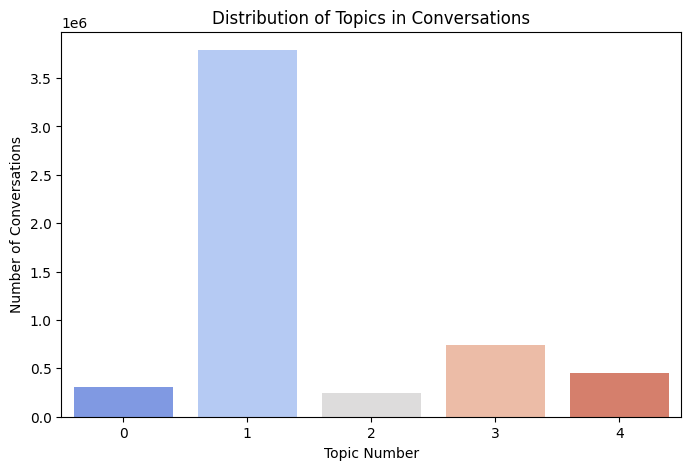

In [40]:
topic_counts = df['topic'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='coolwarm')
plt.title("Distribution of Topics in Conversations")
plt.xlabel("Topic Number")
plt.ylabel("Number of Conversations")
plt.show()

**1. Topic Dominance**
- **Topic 1 is overwhelmingly dominant**, with the highest number of conversations.
- This suggests that a **majority of customer interactions revolve around a single broad topic**.
- Possible reasons:

    -> This topic may represent **general inquiries**, such as account information, transaction status, or common banking FAQs.
  
    -> The model may have clustered **multiple subtopics into one** due to similarity in language use.
  
**2. Smaller, Distinct Topics**
- Topics **0, 2, 3, and 4** each have significantly fewer conversations.
- These likely represent **more specific customer concerns**, such as:
  
    -> **Topic 0 & 4**: Less frequent but **complex issues** (e.g., disputes, fraud reports, technical failures).
  
    -> **Topic 3**: Moderate frequency, possibly **requests requiring agent intervention**.
  
**3. Possible Issues with Topic Imbalance**
- The model may be **overfitting to one major category**, reducing its ability to differentiate nuances.
- There could be **overlapping topics within Topic 1**, leading to poor separation.
- **Improving the model** (e.g., increasing the number of clusters, fine-tuning TF-IDF features) may help separate topics more meaningfully.

### Topic Modelling on Long Conversations

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-41-f39892653cc7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_conversations['topic'] = kmeans.fit_predict(vectorized_long_texts)


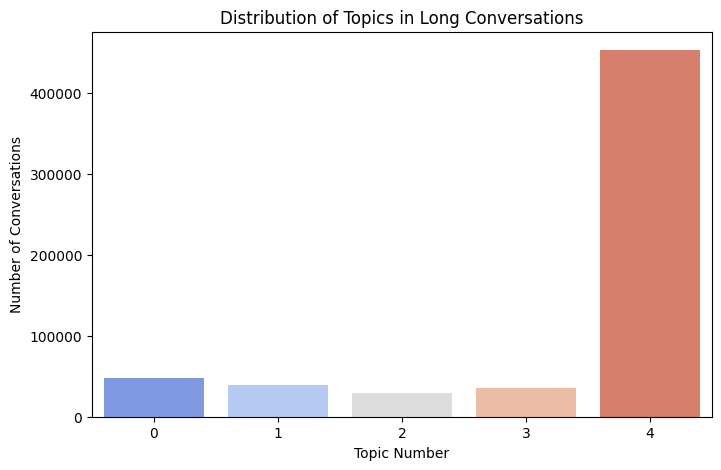

In [41]:
vectorized_long_texts = tfidf.fit_transform(long_conversations['text'].dropna().astype(str))

long_conversations['topic'] = kmeans.fit_predict(vectorized_long_texts)

topic_counts_long = long_conversations['topic'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=topic_counts_long.index, y=topic_counts_long.values, palette='coolwarm')
plt.title("Distribution of Topics in Long Conversations")
plt.xlabel("Topic Number")
plt.ylabel("Number of Conversations")
plt.show()

**1. One Topic (Topic 4) Dominates Long Conversations**
- **Topic 4 accounts for the overwhelming majority of long conversations**, significantly more than any other topic.
- This suggests that **a single issue or category is responsible for most prolonged interactions**.
- Possible reasons:
  
    -> **A complex issue requiring multiple steps to resolve** (e.g., account verification, disputes, or            fraud-related queries).
  
    -> **Chatbot or agent inefficiency** in handling these specific types of queries, leading to unnecessary        back-and-forth.
  
    -> **Lack of clear process or automation**, forcing customers to spend more time explaining or waiting          for answers.
  
**2. Other Topics Are Much Less Frequent**
- Topics **0, 1, 2, and 3** each have **significantly fewer** long conversations compared to Topic 4.
- This suggests that these **other issues are either resolved more efficiently** or are **less common overall**.
- The **even distribution** among the smaller topics indicates **they are not disproportionately causing delays** like Topic 4.
  
**3. Potential Issues with Topic Modeling**
- If Topic 4 **contains too many long conversations**, it might indicate that the **topic modeling algorithm is not distinguishing subtopics effectively**.
- If multiple different issues **are being grouped into one dominant topic**, further **refinement in clustering may be needed**.

### Topic Modelling for Negative Sentiment Conversations

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-42-ce9c3ee5784a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_sentiment_df['topic'] = kmeans.fit_predict(vectorized_texts_negative)


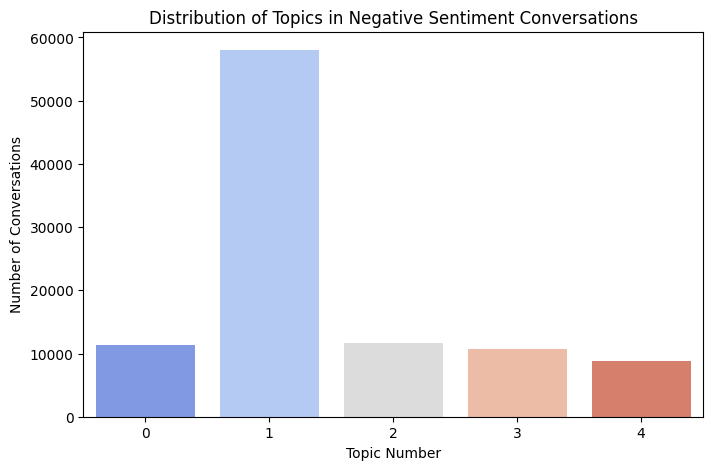

In [42]:
vectorized_texts_negative = tfidf.fit_transform(negative_sentiment_df['text'].dropna().astype(str))

negative_sentiment_df['topic'] = kmeans.fit_predict(vectorized_texts_negative)

topic_counts_negative = negative_sentiment_df['topic'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=topic_counts_negative.index, y=topic_counts_negative.values, palette='coolwarm')
plt.title("Distribution of Topics in Negative Sentiment Conversations")
plt.xlabel("Topic Number")
plt.ylabel("Number of Conversations")
plt.show()

**1. Topic 1 Is the Primary Source of Negative Sentiment**
- **Topic 1 has the highest number of negative sentiment conversations**, significantly more than any other topic.
- This suggests that **a specific issue or category is responsible for most customer frustration**.
- Possible reasons:
  
    -> **Repeated unresolved complaints** – Customers might be encountering the same **unsolved issue**             multiple times.
  
    -> **Difficult processes** – Customers may be frustrated by **complicated account verification, refund          policies, or technical failures**.
  
    -> **Poor chatbot or agent handling** – If chatbots or agents **fail to resolve this issue                      effectively**, it can lead to **escalations and dissatisfaction**.
  
**2. Other Topics Have Significantly Fewer Negative Sentiment Cases**
- Topics **0, 2, 3, and 4** have **similar and much lower volumes** of negative conversations.
- This suggests that while these topics may **occasionally lead to dissatisfaction**, they are **not the primary drivers of customer frustration**.
- Customers **may accept delays or minor inconveniences in these topics** without expressing strong negativity.
  
**3. Possible Issues with Topic Modeling**
- If **Topic 1 is absorbing a disproportionately high number of conversations**, it may indicate that **multiple subtopics are being grouped together**.
- If the model isn’t distinguishing **between different types of customer frustrations, further refining topic clustering** may help identify **specific subcategories**.

### Topic Modelling for Apology Responses

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-43-0ca7611faf1f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apology_responses['topic'] = kmeans.fit_predict(vectorized_texts_apology)


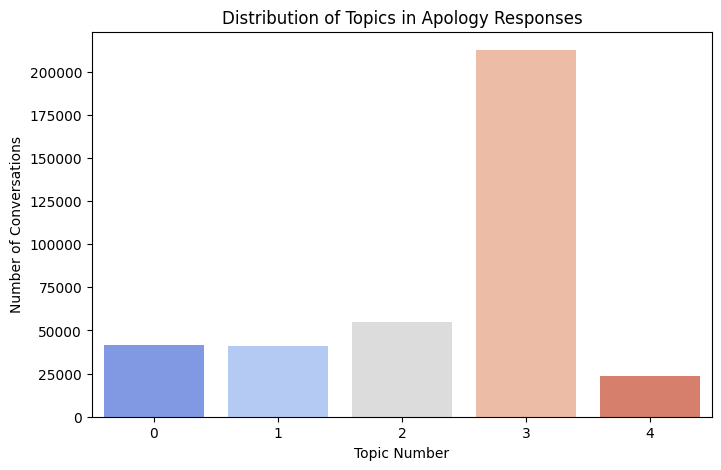

In [43]:
vectorized_texts_apology = tfidf.fit_transform(apology_responses['text'].dropna().astype(str))

apology_responses['topic'] = kmeans.fit_predict(vectorized_texts_apology)

topic_counts_apology = apology_responses['topic'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=topic_counts_apology.index, y=topic_counts_apology.values, palette='coolwarm')
plt.title("Distribution of Topics in Apology Responses")
plt.xlabel("Topic Number")
plt.ylabel("Number of Conversations")
plt.show()

**1. Topic 3 Dominates Apology Responses**
- **Topic 3 has an overwhelmingly higher number of apology responses** compared to all other topics.
- This suggests that a **specific type of issue is driving most customer dissatisfaction, requiring frequent** apologies.
- Possible reasons:
  
    -> **Repeated unresolved problems** – Customers may be **facing persistent issues**, leading agents to          **repeatedly apologize** instead of resolving the problem.
  
    -> **Service failures or delays** – If Topic 3 involves **technical failures, transaction delays, or            account verification issues**, agents may **lack the authority to provide instant solutions**.
  
    -> **Ineffective resolution processes** – If this topic sees **excessive apologies but low resolution           rates**, the process needs to be improved.
  
**2. Other Topics Receive Apologies Less Frequently**
- Topics **0, 1, and 2** each have **a moderate number of apology responses**, but they are **not the primary cause of apologies**.
- Topic **4 has the fewest apologies**, suggesting that **issues in this category are either minor or easier to resolve without requiring an apology**
  .
**3. Possible Issues with Topic Modeling**
- If Topic 3 **absorbs a disproportionate number of apologies**, it might indicate **poor topic separation**, where multiple subtopics are being combined.
- Further **sub-topic analysis within Topic 3** can help **break it down into more specific problem areas**.


# 2. Customer Satisfaction Score Classification

In [44]:
def classify_satisfaction(score):
    if score > 0.3:
        return "Satisfied"
    elif score < -0.3:
        return "Not Satisfied"
    else:
        return "Neutral"

df['satisfaction'] = df['sentiment'].apply(classify_satisfaction)

## Aggregate satisfaction by conversation

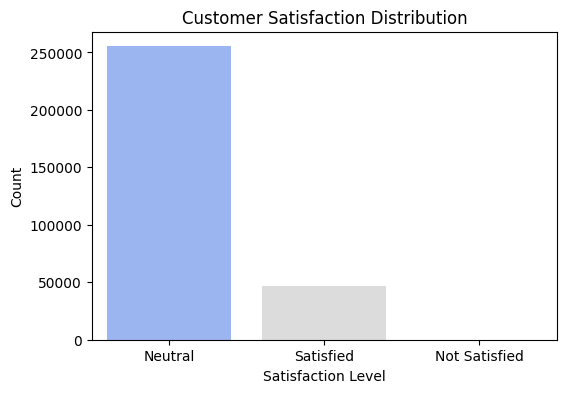

In [45]:
df_satisfaction = df.groupby('conversation_id')['satisfaction'].apply(lambda x: x.mode()[0]).reset_index()

plt.figure(figsize=(6,4))
sns.countplot(x=df_satisfaction['satisfaction'], palette='coolwarm')
plt.title("Customer Satisfaction Distribution")
plt.xlabel("Satisfaction Level")
plt.ylabel("Count")
plt.show()

**1. Majority of Conversations are Neutral**
- The **overwhelming majority of interactions fall under "Neutral"**.
- This suggests that most conversations are **transactional or informational** rather than emotional (positive or negative).
- Possible reasons:
  
    -> Customers are **getting basic information** without expressing strong emotions.
  
    -> The sentiment scoring model might **not be sensitive enough** to detect subtle satisfaction or dissatisfaction.
  
**2. Low Satisfaction Rate**
- The **number of "Satisfied" customers is significantly lower** than neutral.
- This could indicate:
  
    -> A **lack of delightful customer experiences**—most responses may solve issues but don’t exceed expectations.
  
    -> Customers may be **hesitant to explicitly express satisfaction** in text-based conversations.
  
**3. Very Few "Not Satisfied" Cases**
- The **almost negligible count of "Not Satisfied"** conversations is surprising.
- Possible explanations:
  
    -> **Dissatisfied customers may drop off before expressing frustration**.
  
    -> The sentiment analysis approach might **not be effectively capturing negative tones**.
  
    -> Many complaints might be worded **politely or indirectly**, making them harder to detect.

In [46]:
# Save Results
df_satisfaction.to_csv("customer_satisfaction_scores.csv", index=False)
print("Customer Satisfaction Scores saved!")

Customer Satisfaction Scores saved!


# Load Advanced NLP Sentiment Analysis Model

In [50]:
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=0)

# Optimize sentiment analysis by processing in batches
def get_advanced_sentiment(text):
    """Process a list of texts in batches to improve GPU efficiency"""
    results = sentiment_pipeline(list(text), truncation=True)
    labels = [res['label'] for res in results]
    scores = [res['score'] for res in results]
    return labels, scores
    # """Classify sentiment using BERT-based model"""
    # try:
    #     result = sentiment_pipeline(text[:512]) # Limit to 512 tokens for BERT compatibility
    #     label = result[0]['label']
    #     score = result[0]['score']
    #     return label, score
    # except Exception as e:
    #     return "Neutral", 0.5 # Default neutral sentiment if processing fails

Device set to use cuda:0


In [ ]:
# # df[['sentiment_label', 'sentiment_score']] = df['text'].apply(lambda x: pd.Series(get_advanced_sentiment(x)))
# # Apply sentiment model efficiency in batches
# batch_size = 64 # Adjust based on available GPU memory
# sentiment_labels, sentiment_scores = [], []
# for i in range(0, len(df), batch_size):
#     batch_texts = df['text'].iloc[i:i+batch_size]
#     labels, scores = get_advanced_sentiment(batch_texts)
#     sentiment_labels.extend(labels)
#     sentiment_scores.extend(scores)

# df['sentiment_label'] = sentiment_labels
# df['sentiment_score'] = sentiment_scores

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# # Map sentiment labels to satisfaction categories
# def map_satisfaction(label):
#     if "5 stars" in label or "4 stars" in label:
#         return "Satisfied"
#     elif "1 star" in label or "2 stars" in label:
#         return "Not Satisfied"
#     else:
#         return "Neutral"

# df['satisfaction'] = df['sentiment_label'].apply(map_satisfaction)

In [ ]:
# # Aggregate satisfaction by conversation
# df_satisfaction_nlp = df.groupby('conversation_id')['satisfaction'].apply(lambda x: x.mode()[0]).reset_index()

# plt.figure(figsize=(6,4))
# sns.countplot(x=df_satisfaction_nlp['satisfaction'], palette='coolwarm')
# plt.title("Customer Satisfaction Distribution Using Advanced NLP Model")
# plt.xlabel("Satisfaction Level")
# plt.ylabel("Count")
# plt.show()

# # Save results
# df_satisfaction_nlp.to_csv("customer_satisfaction_scores_advanced.csv", index=False)
# print("Customer Satisfaction Scores using Advanced NLP Model saved!")